In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM5.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

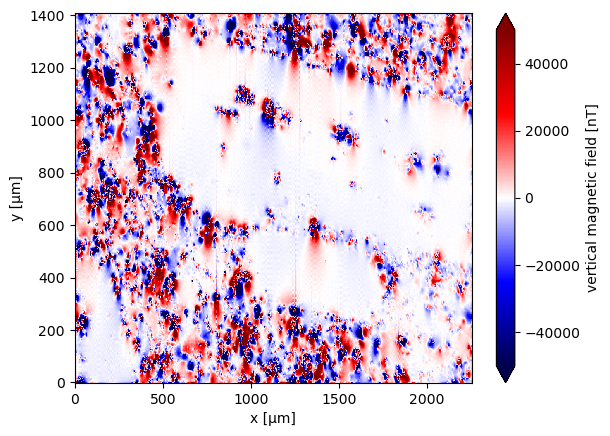

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 2.156e+04 2.511e+04 ... 7.613e+03 1.355e+04

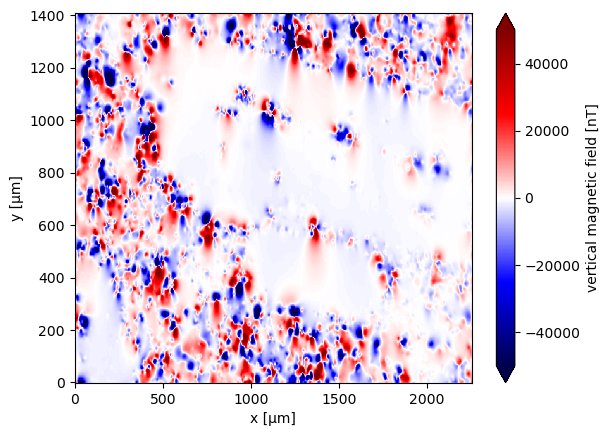

In [6]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 2.156e+04 2.511e+04 ... 7.613e+03 1.355e+04
    tga      (y, x) float64 5MB 5.716e+03 6.527e+03 ... 2.144e+03 3.226e+03
    x_deriv  (y, x) float64 5MB 1.508e+03 409.7 ... 2.123e+03 2.526e+03
    y_deriv  (y, x) float64 5MB -358.5 -180.3 26.08 ... -97.43 84.62 686.5
    z_deriv  (y, x) float64 5MB -5.502e+03 -6.512e+03 ... -286.1 -1.885e+03

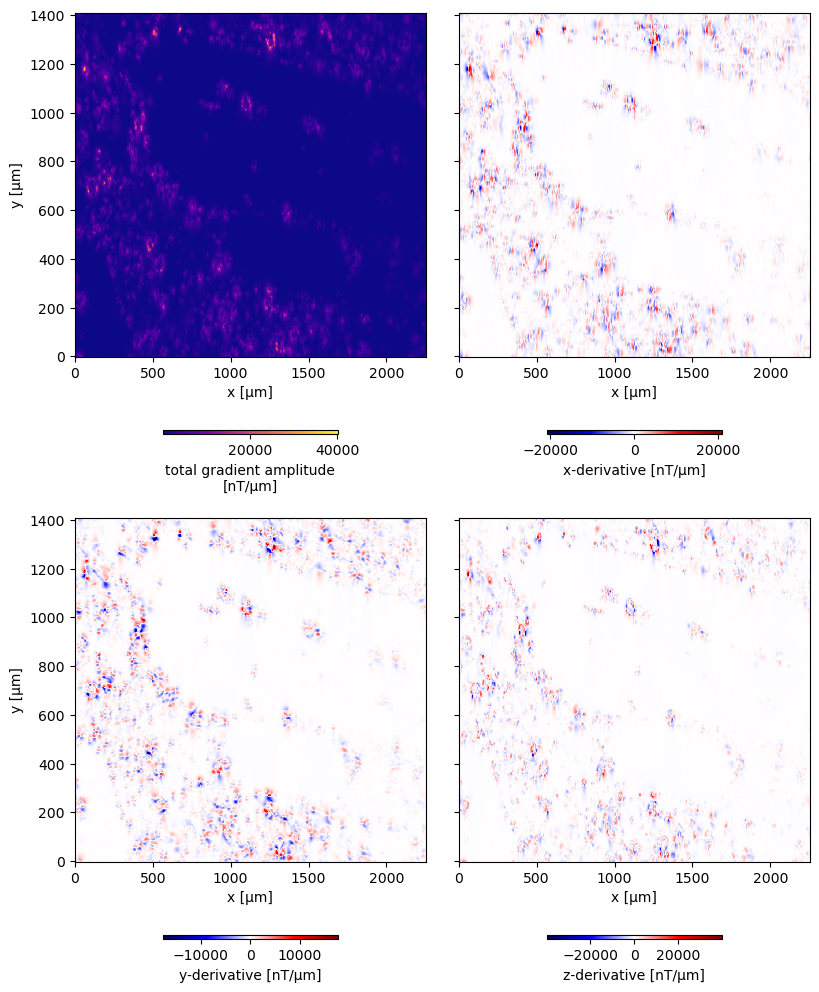

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

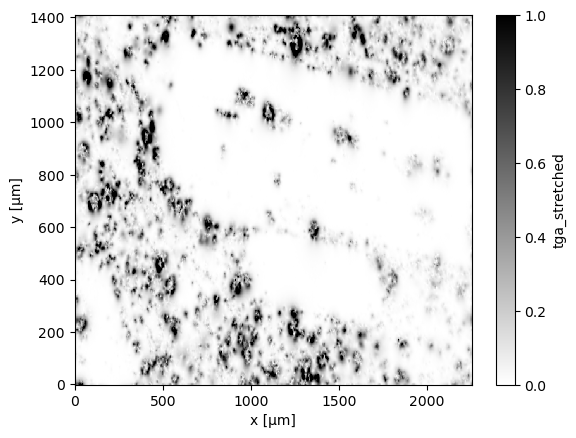

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 100],
    size_increment=1.0,
    threshold=0.05,
    overlap=1.0,
    exclude_border=30,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

538 potential sources detected within 1.7653 seconds


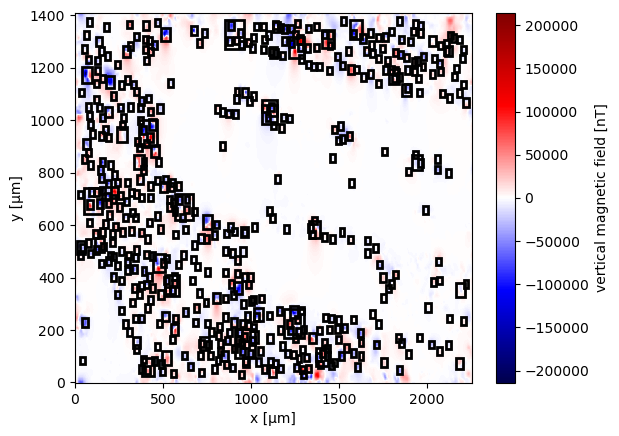

In [13]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

538 euler positions and dipole moments estimated within 3.5541 seconds


# Iterative Euler deconvolution

In [16]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 153.571 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x       y     z            bz      z_deriv
0  488.80  1301.9  10.0  29743.351016 -1592.435157
1  491.15  1301.9  10.0  33086.610147 -1917.842373
2  493.50  1301.9  10.0  35391.211573 -2014.478608
3  495.85  1301.9  10.0  36829.800958 -1938.168149
4  498.20  1301.9  10.0  37878.407152 -1781.638365

In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [22]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

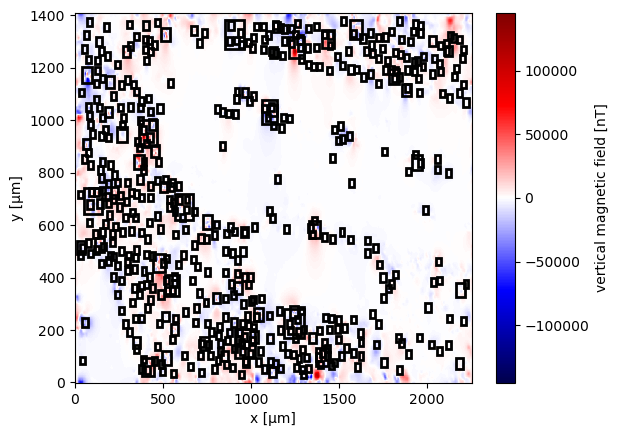

In [23]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

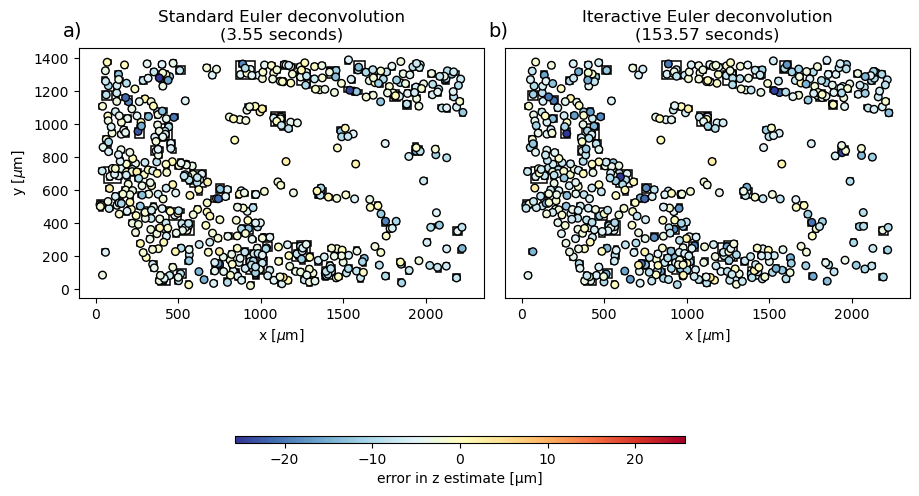

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

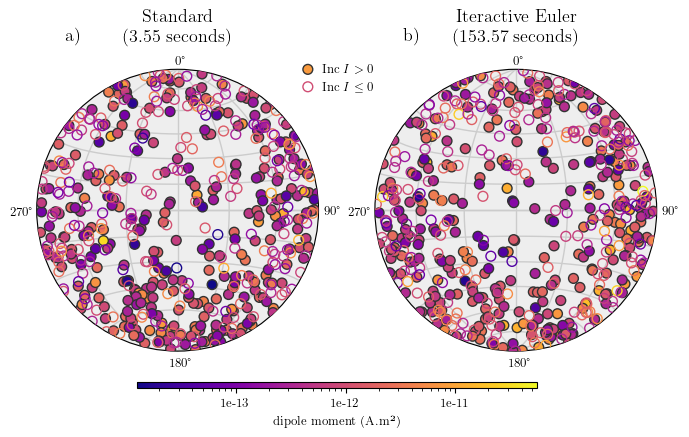

In [26]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

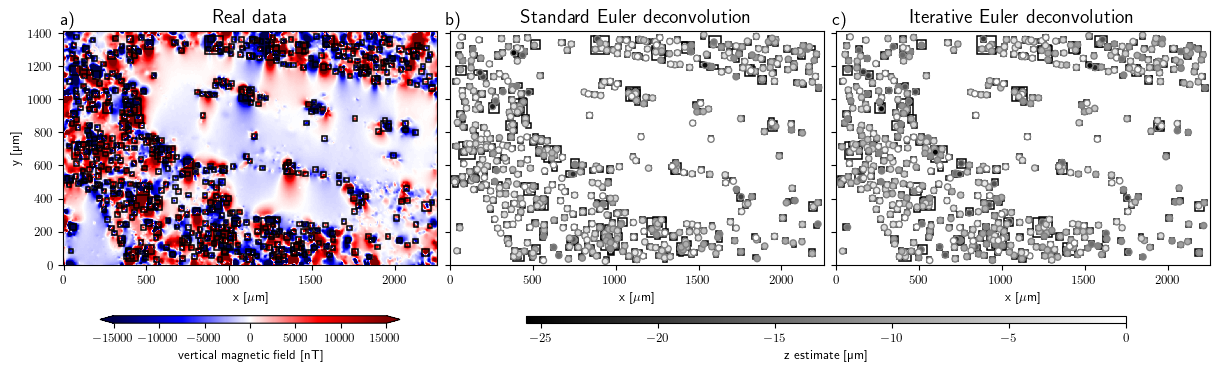

In [27]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


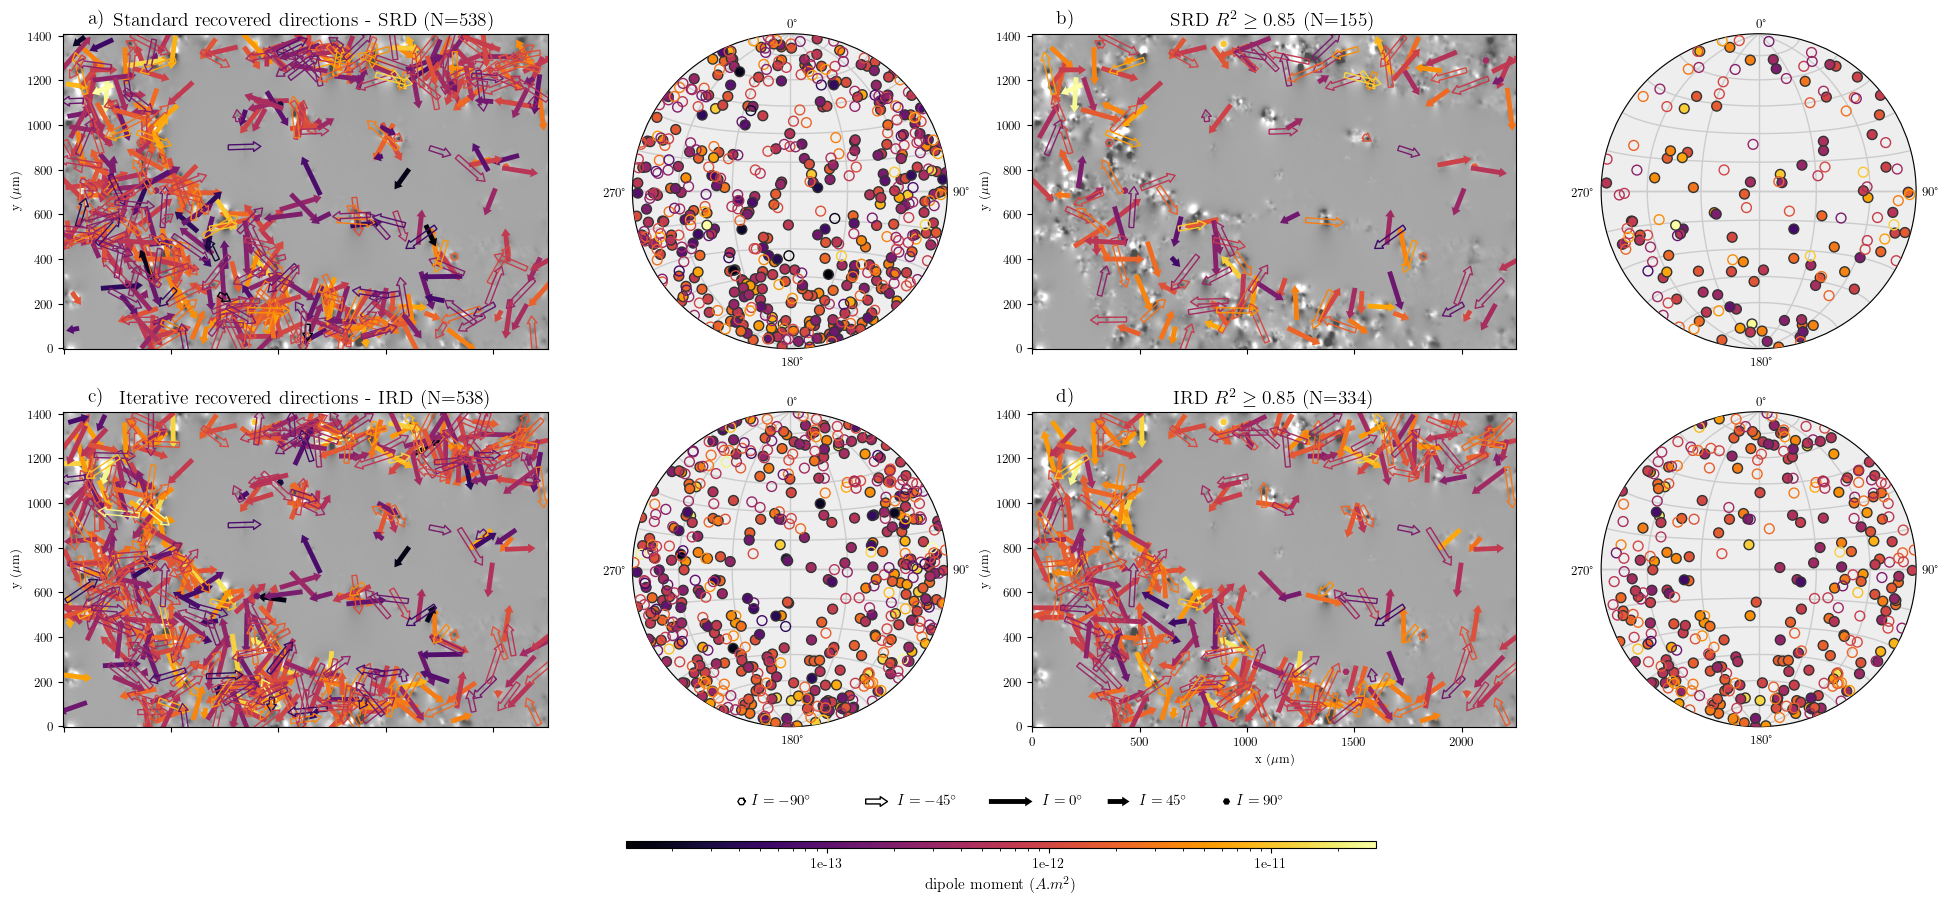

In [28]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

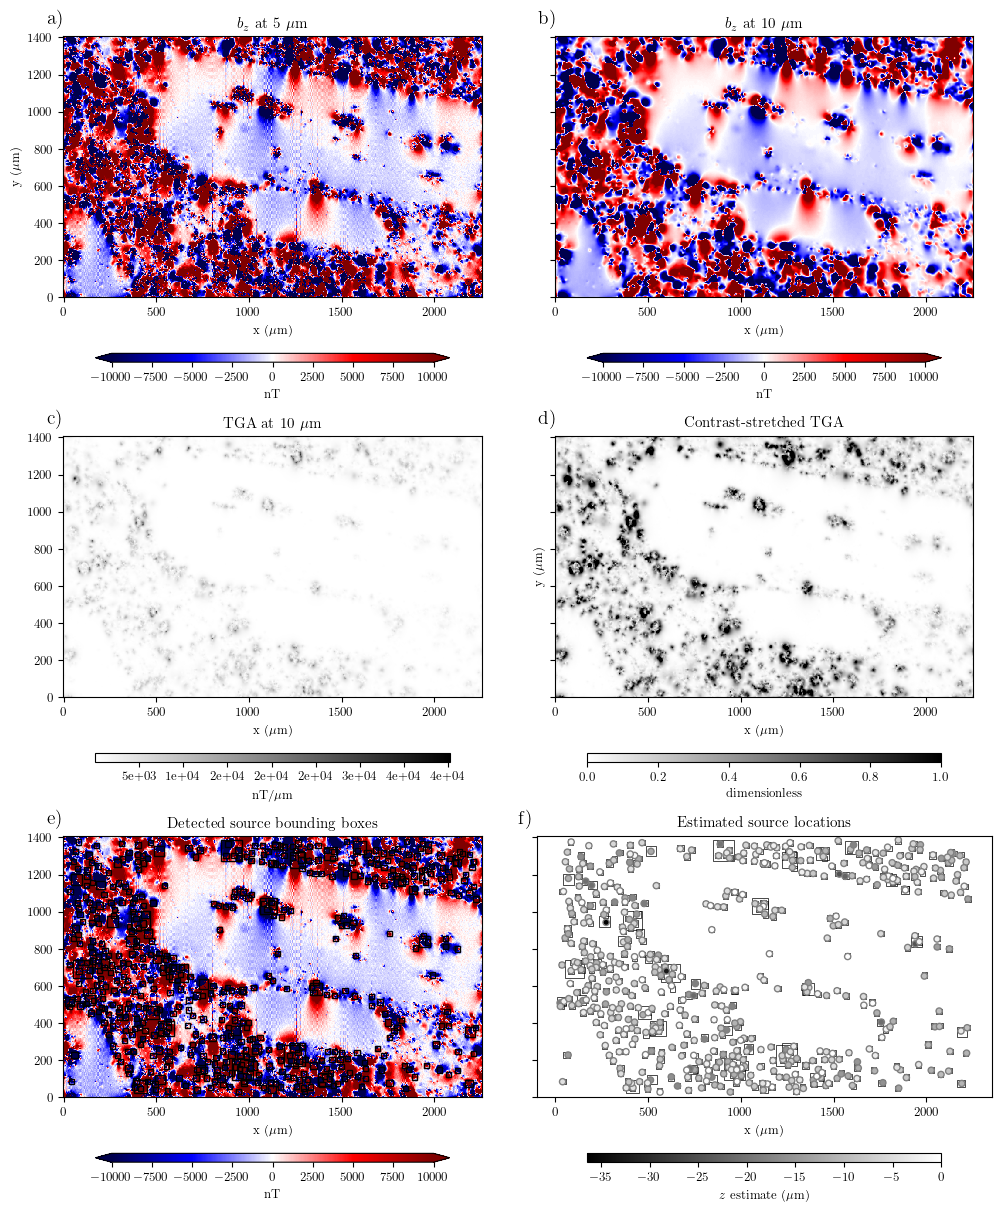

In [29]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [30]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [31]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 2.157e+04 2.509e+04 ... 7.644e+03 1.356e+04
    tga      (y, x) float64 5MB 5.71e+03 6.52e+03 ... 2.137e+03 3.219e+03
    x_deriv  (y, x) float64 5MB 1.499e+03 401.9 ... 2.116e+03 2.518e+03
    y_deriv  (y, x) float64 5MB -351.4 -174.7 30.85 ... -86.46 94.42 694.8
    z_deriv  (y, x) float64 5MB -5.498e+03 -6.506e+03 ... -283.6 -1.881e+03

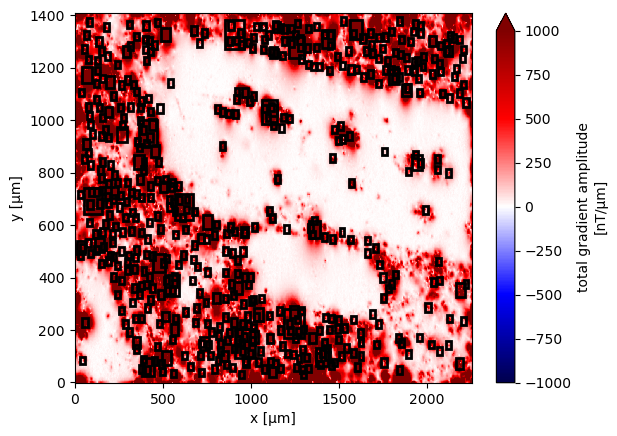

In [32]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [33]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [34]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.025,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [35]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

543 potential sources detected within 1.5355 seconds


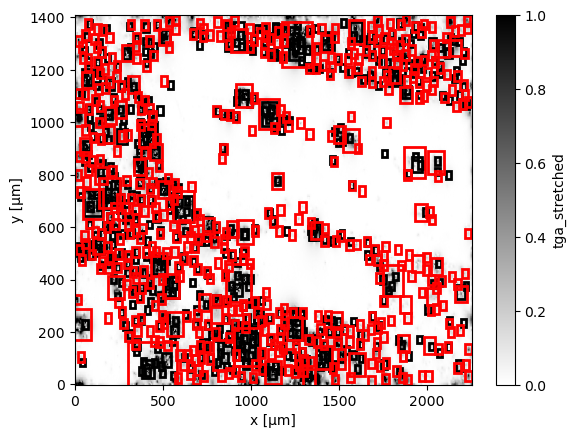

In [36]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [37]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[1746.46522369 1783.23477631    2.76522369   39.53477631]
[  -5.81267031   57.51267031  985.88732969 1049.21267031]
[1701.81522369 1738.58477631 1368.11522369 1404.88477631]
[2115.41522369 2152.18477631 1363.41522369 1400.18477631]
[1863.96522369 1900.73477631 1372.81522369 1409.58477631]
[ -4.28477631  32.48477631 305.91522369 342.68477631]
[ 515.06522369  551.83477631 1365.76522369 1402.53477631]
[   2.76522369   39.53477631 1292.91522369 1329.68477631]
[ -1.93477631  34.83477631 780.61522369 817.38477631]
[ 994.46522369 1031.23477631    7.46522369   44.23477631]
[1.45976522e+03 1.49653478e+03 4.15223689e-01 3.71847763e+01]
[2209.41522369 2246.18477631 1368.11522369 1404.88477631]
[2218.81522369 2255.58477631   14.51522369   51.28477631]
[1873.36522369 1910.13477631   -1.93477631   34.83477631]
[ 555.01522369  591.78477631 1370.46522369 1407.23477631]
[2218.81522369 2255.58477631  115.56522369  152.33477631]
[1666.56522369 1703.33477631   -4.28477631   32.484

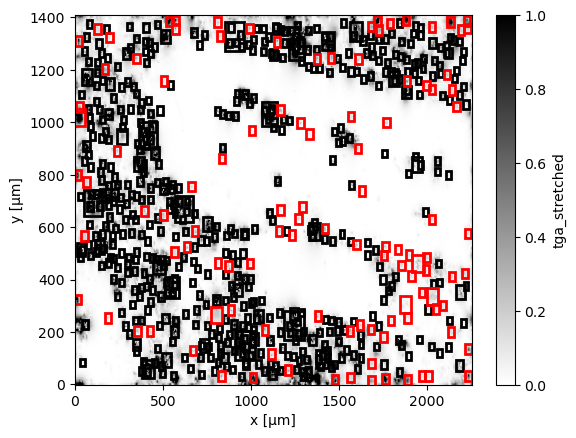

In [38]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [39]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[1767.80867493   24.14736036   -8.07577206]

[ 1.10289147e-12  3.69926045e-13 -1.07244106e-12]

(42.67336937847308, 71.45778846894422, 1.5821961600862937e-12)

0.8222178644639291

[  22.81889134 1018.56025939  -11.25482744]

[ 1.01203586e-12 -6.38582965e-12  1.51184319e-12]

(-13.161083013739969, 170.99457507996922, 6.639932739562424e-12)

0.9588252253630197

piorou

[1715.82101641 1385.19034101   -6.5207299 ]

[ 1.43075972e-12 -6.08125238e-17  7.54700752e-13]

(-27.81086360303935, 90.00243528029287, 1.6176052069101294e-12)

0.8684146089318713

[2131.27448657 1390.49217765  -18.59260891]

[ 1.88000326e-12 -9.10356466e-12  3.79310425e-12]

(-22.19796848609199, 168.33171338294676, 1.0039768010511534e-11)

0.9691794219088722

[1883.59116468 1394.14645361   -8.68489376]

[ 9.37441489e-13  1.74019377e-12 -1.03994498e-12]

(27.74975018432872, 28.31132369535014, 2.23350766016378e-12)

0.915014671769977

[  9.7332185  322.4029572   -7.75509725]

[-8.57789033e-13 -1.28280293e-13 -7.99692513e-13]

(42.676631063778274, -98.5054138231525, 1.1797313142523058e-12)

0.9394881922778261

[ 541.38818577 1390.41175787   -5.91411471]

[3.93237114e-13 1.47021693e-12 3.22117579e-13]

(-11.9505781951569, 14.974314682483632, 1.5556133751618219e-12)

0.824616258228876

[  21.45543681 1308.39944129   -5.29265674]

[-2.02147439e-13  5.97760222e-13  1.56432172e-13]

(-13.923232370670995, -18.68424082353996, 6.501168312867437e-13)

0.9462082758690672

[ 11.54350283 804.13937211  -8.36409177]

[ 1.35770452e-12 -7.80019313e-13  2.85149893e-13]

(-10.320975555331296, 119.87794080073374, 1.5915722237079973e-12)

0.9485268642062842

[1024.04418727   18.6087711   -10.26949543]

[-3.05310894e-12  3.40308228e-13 -1.27723579e-12]

(22.5758146850433, -83.63990155189141, 3.3269528293574527e-12)

0.8890575217472074

[1475.82855241   24.97421277  -19.49564537]

[ 2.88988688e-12 -2.84415239e-12 -2.33318522e-12]

(29.91725640400708, 134.54302069727865, 4.6780767697815e-12)

0.8353303800193801

[2220.54329252 1391.25057099   -6.29846216]

[-4.59222889e-13  1.78107037e-13 -3.25810606e-13]

(33.48360444785361, -68.80149477031776, 5.905593366406306e-13)

0.7203214290281661

[2235.03522552   27.13650762  -12.53827319]

[5.48622510e-13 9.40070853e-13 1.10823511e-12]

(-45.51608061049984, 30.2677065176857, 1.5533528030872794e-12)

0.9324568830564932

[1888.04818977   22.34413979  -18.63627742]

[-2.98437134e-12 -2.68287237e-12  3.43217693e-12]

(-40.53910581144203, -131.9547191300005, 5.28054115389803e-12)

0.9700613084752993

[ 565.41957008 1387.32661385   -1.87104228]

[-1.99676869e-13 -9.32859348e-14 -1.10686547e-13]

(26.66686859083017, -115.0412515958514, 2.466264976326749e-13)

0.6942512040385447

[2246.3140761   135.63077099  -11.89999548]

[-7.75796348e-13 -5.76456343e-13  6.17145702e-13]

(-32.55917284427281, -126.61423591816656, 1.1467478826631853e-12)

0.8784897854219311

[1686.29430339   12.17902657  -10.29714491]

[ 8.94535863e-13  5.26283914e-13 -1.10225720e-13]

(6.062317803319944, 59.53034635279773, 1.043704401271185e-12)

0.9636146344170444

[1560.99577566  203.94178472   -7.75156967]

[-3.83659138e-13  6.94289391e-14 -1.61575121e-13]

(22.509673983157118, -79.74247091603696, 4.2204411069467244e-13)

0.8128308990575186

[1.88413463e+03 1.15373114e+03 1.80622073e+00]

[-1.94604048e-14 -1.25634144e-14 -1.74245847e-14]

(36.95209014900667, -122.84582364861397, 2.8985563457001084e-14)

0.6350789290488807

[1372.7340995  1240.81709913   -8.06534611]

[2.29236671e-13 9.89391402e-14 2.67721275e-13]

(-46.99742763914837, 66.65484723853457, 3.6607797733851884e-13)

0.9376767044119367

piorou

[1.59455754e+03 5.34201461e+02 7.29850869e-01]

[ 2.31465590e-14  1.32757498e-14 -2.91744256e-15]

(6.239655967523432, 60.16349717415175, 2.6842507248526298e-14)

0.2147359260908679

[1163.58714958 1046.38458628   -6.33862701]

[ 2.69847868e-13 -7.95795690e-14 -1.05459883e-13]

(20.54860418715628, 106.4310680784201, 3.004539340043977e-13)

0.9289786189666076

[1417.90400276  593.25503415   -2.64364025]

[ 3.01587406e-14  1.20406865e-13 -8.09285756e-15]

(3.730320361655727, 14.061779493653157, 1.2438994023867253e-13)

0.9186537880148103

[2028.19249015 1371.33090055  -12.57960292]

[ 1.96980521e-13  6.94384947e-13 -1.99816109e-13]

(15.474032525542095, 15.83738017983086, 7.489314105592674e-13)

0.91083139144891

[1763.4706767   525.58814571   -5.05060174]

[ 1.39036200e-13  5.68311494e-15 -1.38252031e-14]

(5.673889335777623, 87.65933377579343, 1.3983740194518847e-13)

0.9476892695969736

[1954.97016627  446.71785014   -3.51282451]

[ 1.01818692e-13  3.57194252e-14 -4.08101847e-14]

(20.717317199867725, 70.66841393938824, 1.1536201480104153e-13)

0.33838118907889947

[358.77454739 210.47199069 -12.5375399 ]

[-7.75574502e-13 -6.15493171e-14  1.51507955e-14]

(-1.1156201837825723, -94.53746308683793, 7.781604413066371e-13)

0.9701975482854844

[ 1.38524350e+03  2.62992492e+02 -2.32367906e-01]

[ 2.05578522e-14  2.06288220e-14 -1.51719764e-14]

(27.517462957481218, 44.90127234923289, 3.2838429527653346e-14)

0.674168725488061

[2117.82580179 1186.68425859  -17.66624281]

[-1.23077110e-12  6.22941073e-13  5.67001617e-13]

(-22.344510708263144, -63.15425613044248, 1.4914234562859544e-12)

0.940101308129024

[1691.21534459 1365.16170922  -17.19676945]

[ 1.37256565e-12 -6.63829692e-13 -1.00844345e-12]

(33.48141826914256, 115.81033719033964, 1.8279946689987114e-12)

0.9347807172449664

[1077.12328016  210.71161164  -14.60221137]

[ 3.93511275e-13 -9.11042203e-13 -2.18710407e-13]

(12.428529126215064, 156.63878025512096, 1.0162102448856805e-12)

0.942057542096555

[2004.85146976  483.79436782   -4.83255173]

[-9.69461979e-14 -7.47487532e-15  6.37290633e-14]

(-33.24163289409381, -94.40897257348989, 1.1625761284371489e-13)

0.7937608470414301

piorou

[1.76718608e+03 1.00113141e+03 1.62109383e-01]

[-1.51287501e-14  1.05931147e-14 -1.13200653e-14]

(31.5054729057103, -55.00038150849031, 2.1661879772095963e-14)

0.609333941002416

[1745.96507192  476.55618989   -5.28443586]

[-1.91146879e-13 -1.05617769e-13  8.46993501e-15]

(-2.221064762585262, -118.92274430577321, 2.1854972494669305e-13)

0.456415029254439

[2039.02981109  344.23636621  -22.74785678]

[ 2.71225686e-12  1.42476951e-12 -1.26268773e-16]

(0.002361409197476744, 62.28670678653814, 3.0637077948278077e-12)

0.845636228563069

[ 1.21332883e+03  5.48036606e+01 -1.18478494e+00]

[-3.38248592e-14  5.99058050e-14 -3.82987782e-14]

(29.104877330501463, -29.450553466686024, 7.873768466800354e-14)

0.7417191144187891

[ 988.08800407 1362.08068955   -9.4049011 ]

[-3.84180092e-13  3.22401214e-13 -2.58569774e-14]

(2.951312567911418, -49.99686347009347, 5.02200626434433e-13)

0.8983894993130302

[ 344.75071577 1241.9703655    -3.35273473]

[ 3.73230656e-14 -9.70934389e-14 -7.48424443e-14]

(35.73505202245535, 158.97306132863065, 1.281465511125401e-13)

0.7837648934385233

[1165.45465829  585.28309356  -10.45385982]

[ 2.79713195e-13 -1.60336079e-13 -1.05657504e-13]

(18.144659291146674, 119.82202484243435, 3.392795863578992e-13)

0.9157195440366397

[237.30219303 895.15308931  -4.23436868]

[ 2.19772738e-14 -9.44075198e-14  4.14441918e-14]

(-23.149622859093334, 166.89541979266232, 1.054201185840743e-13)

0.8434698311296613

[ 570.23051487 1355.20439568   -2.83581133]

[3.59094885e-14 1.06731465e-13 2.05669026e-14]

(-10.350293417703124, 18.595361962166614, 1.1447311718750555e-13)

0.8915007381185784

[875.05255498 447.9278883   -0.93424466]

[ 1.00496407e-14 -5.40646068e-14 -1.93313841e-14]

(19.368571826047493, 169.46992350691323, 5.828961655374961e-14)

0.6649840995844587

[2139.03324111  409.11963052   -7.78507715]

[-1.09677287e-13 -1.96542261e-13 -2.41140239e-14]

(6.115260155448294, -150.8369920824346, 2.2636133470311628e-13)

0.9465683535119511

piorou

[1450.9852597  1250.28615106   -5.85917817]

[-2.47207094e-13 -1.85806780e-13  4.38966031e-14]

(-8.078901768227668, -126.92940156745738, 3.1234983348815564e-13)

0.6309755968562076

[2169.1949165  1059.05017429  -14.44727761]

[-4.00658929e-13 -6.23960004e-13 -9.98995488e-14]

(7.672829269398455, -147.29455600044227, 7.48220277310938e-13)

0.9753716631081049

[1968.55077921   31.29519638  -10.13532413]

[-2.98866721e-14 -2.66358624e-13  5.86665687e-14]

(-12.346224435433209, -173.59792549419868, 2.7437546547665446e-13)

0.8049528074173053

[688.91404757 584.35887544  -9.46538458]

[ 3.01489164e-13 -1.53115182e-13 -1.13688460e-13]

(18.58342682902213, 116.92432847553302, 3.5674226095796176e-13)

0.8699390756285829

[2141.80654593  200.41999202   -5.45277126]

[-7.90757264e-14  1.04570542e-13  2.44165031e-14]

(-10.549856370979311, -37.096391236284596, 1.3335716817568513e-13)

0.886902724977606

[2026.50329646  623.39556115   -3.63033455]

[-5.19558338e-14 -6.85667427e-14 -7.04151047e-15]

(4.679310411192115, -142.84729759157028, 8.631564020066478e-14)

0.7909786632857767

[394.77910926 657.96056809 -19.29514044]

[ 8.80288406e-13 -1.30897985e-12  3.86838048e-14]

(-1.4047863344651685, 146.07918463255365, 1.5779202668409558e-12)

0.8482767400993715

[1799.68722484 1374.23759732  -15.38593158]

[-1.19050977e-12  2.52439564e-13  2.97418294e-13]

(-13.733354077786153, -78.02814197987557, 1.2527956247902822e-12)

0.8698546491538497

[837.04094645  42.79715025  -5.35970915]

[1.51948584e-13 1.89716896e-13 7.29289107e-14]

(-16.701242152511686, 38.69203254007121, 2.537705636311814e-13)

0.8334188692656872

piorou

[2223.7945412   415.80110187   -9.3793491 ]

[-2.57144133e-13  1.54166295e-13 -1.55278654e-13]

(27.38014046367025, -59.05593811652458, 3.376415439062906e-13)

0.6081777111207118

[1274.06928707  632.35988105   -2.9259269 ]

[ 4.53595998e-14  2.11335350e-14 -1.51070350e-14]

(16.79864880470883, 65.01867213386116, 5.2271809851675164e-14)

0.8394943168885559

[661.44561896 750.42694975  -5.43831597]

[4.49790960e-14 6.69751182e-14 5.42919477e-14]

(-33.938743446032376, 33.8844878256938, 9.724402870852512e-14)

0.9835369929005299

[631.90528139 520.57055257  -5.64319854]

[-4.17628627e-14 -1.03575864e-13 -4.96368352e-14]

(23.963315269267184, -158.04019652990758, 1.2221256741961416e-13)

0.7246344699289984

[1284.49727668  996.03234063    1.48821808]

[ 7.29859318e-15  5.52175300e-15 -6.43420388e-15]

(35.10865740512205, 52.89066100934414, 1.1187412491450642e-14)

0.8914481699603181

piorou

[2202.47278791 1357.75549687   -4.97749097]

[-2.14654185e-13  8.28474725e-15 -1.11760735e-14]

(2.9782277287274614, -87.78972135475126, 2.151045348140894e-13)

0.49042668408977896

[1570.73674862 1017.99277054   -8.04319845]

[ 4.63757084e-14 -1.62502185e-13 -6.60554684e-14]

(21.349711875742067, 164.0720411560678, 1.814414272017883e-13)

0.9804866712810841

[1920.17663693  417.20479654   -4.13230422]

[ 2.13420079e-14  5.73283891e-14 -3.22200799e-14]

(27.776316133708548, 20.419112561473657, 6.913869431909114e-14)

0.7716173129984784

[1721.76375691 1342.59814497  -14.93771229]

[1.87199032e-12 1.01390399e-12 1.67652165e-13]

(-4.502718250650028, 61.5592192282663, 2.13552248734655e-12)

0.7783272960718413

[ 163.27894369 1185.33069615  -21.16977338]

[-4.88006711e-12  5.31947503e-13 -8.43506511e-14]

(0.9844136485778201, -83.77908419304026, 4.909698376492337e-12)

0.7970967629221181

piorou

[2142.45738588 1129.091545     -4.19806152]

[-4.68313298e-14  7.63337803e-14 -7.01894483e-14]

(38.087994245699775, -31.529418746616166, 1.137830309065963e-13)

0.2990153719680715

[563.65668572 507.91770174 -19.32818442]

[-3.61295621e-13  1.10197165e-12 -4.64209704e-13]

(21.815656694832374, -18.15239797506525, 1.2491463843630582e-12)

0.9487842684049133

[1897.46524888  488.33691117   -3.6344015 ]

[-3.10320600e-14 -4.49129833e-14 -9.02596131e-15]

(9.388250491024449, -145.3579545648207, 5.533202324371312e-14)

0.7012987453848144

piorou

[436.80724569 196.50766501  -0.58578529]

[ 3.82063377e-14 -1.21776555e-16 -8.62349599e-15]

(12.718954289326602, 90.18262046163433, 3.9167636550673103e-14)

0.3806849778897089

[ 806.07808826 1388.03633251  -25.68277069]

[-2.21249428e-12  1.25247127e-12  6.13494897e-13]

(-13.566416064015574, -60.486226073530446, 2.6153759268407537e-12)

0.893820470691567

[1685.6345311    89.4088721   -18.08046473]

[-1.08280745e-12 -1.50379568e-13 -5.02365164e-13]

(24.680504017975892, -97.90662509172944, 1.203102968993806e-12)

0.8709356454190061

[ 9.90890849e+02  4.53159552e+02 -3.26862081e-01]

[ 1.98969900e-15 -2.23814042e-14 -7.87357361e-15]

(19.310916363047713, 174.91978040369818, 2.3809227607220477e-14)

0.4990009373436275

[ 53.42195937 546.5856749  -25.13445293]

[-1.01703069e-12  5.63292761e-12 -1.10266158e-12]

(10.90378442146425, -10.234549798998827, 5.8292441576336095e-12)

0.9523374075665657

[804.91297914 273.55472638 -24.46714089]

[ 5.88278003e-13 -4.37762429e-12  2.25543726e-12]

(-27.050193931093975, 172.34627742916345, 4.95950225748279e-12)

0.8508997344604693

piorou

[8.88115992e+02 2.94627849e+02 2.67949844e-01]

[-5.70638253e-15 -2.83264913e-14 -1.22336393e-14]

(22.946559510670745, -168.61018519912986, 3.1378572957694935e-14)

0.2679079636046481

piorou

[1.89629956e+03 2.49335440e+02 1.01710268e-01]

[ 1.33572619e-14 -9.71796658e-15 -8.28110109e-15]

(26.625885208298968, 126.03745602767918, 1.847787746232169e-14)

0.5482755261728198

[190.88738014 254.28640287  -4.37461214]

[-3.91180677e-14 -1.05066743e-14  3.06665378e-14]

(-37.12989507043356, -105.03418568625165, 5.0804034930163294e-14)

0.9862092311419878

[497.91014521 638.57297182 -17.71822012]

[ 6.85937331e-13 -1.87313946e-12 -2.40071554e-14]

(0.6895195575017907, 159.8874403459417, 1.9949280151717323e-12)

0.9543231601470796

[2100.16053587  281.1010297   -16.71769651]

[-4.79012259e-13  1.65880881e-13 -4.39846534e-13]

(40.947590575444465, -70.89914397478059, 6.711439371956055e-13)

0.76689198155218

[1852.1373537   451.38877566   -7.48632259]

[ 1.20338041e-13  1.00035750e-13 -3.12323938e-14]

(11.286996708196185, 50.26360839513278, 1.5957398907427175e-13)

0.8615412834948903

piorou

[ 2.04775036e+03  2.88348671e+02 -1.81736907e+00]

[ 3.72494124e-14 -2.20610747e-15  2.10038893e-14]

(-29.37452332228565, 93.3894002570178, 4.2819960309844484e-14)

0.657493974540094

[ 820.26372207 1337.89464361  -24.78632563]

[-2.67935310e-12  2.48852040e-13  5.97148621e-13]

(-12.512051639246746, -84.69372504698042, 2.7563466521666923e-12)

0.9821230532738835

[1124.28989978  115.41862436   -5.30866957]

[1.30418010e-13 8.03429314e-14 3.37361363e-14]

(-12.420521921435862, 58.365199122502645, 1.5685015431128375e-13)

0.888018830687893

[1613.16490587 1251.68071335   -8.89562898]

[-2.85105366e-13 -1.46257710e-13 -2.84365059e-14]

(5.071393873159841, -117.15760995904617, 3.216908798756862e-13)

0.7265541144771004

[1661.39309052  207.05816244  -14.86146682]

[ 1.07481055e-12 -1.04881824e-12 -3.45035556e-13]

(12.939510693722605, 134.29875913477073, 1.5408721387736214e-12)

0.816665649309297

[1233.82089264  571.61393712   -4.87900611]

[-7.07746762e-14  4.24877970e-14  1.97788034e-15]

(-1.3725556582848788, -59.02255963832504, 8.257226952920182e-14)

0.9487005781984754

[2240.23289723 1367.83041574  -10.71637485]

[ 3.69479353e-13  7.53592551e-13 -1.09452898e-13]

(7.430037852210691, 26.118279482217577, 8.464021869166587e-13)

0.8412638163971254

[ 502.74902436 1160.4979474   -12.82670114]

[-5.18023120e-14  1.69119846e-13 -2.29680703e-13]

(52.40035777091825, -17.030106149066388, 2.8989347580200707e-13)

0.9647441215413279

piorou

[ 129.77142264 1357.72297531  -10.22672025]

[-3.36051383e-14 -9.09845564e-14  3.89361790e-13]

(-76.01199222900898, -159.72829517811795, 4.012606365824282e-13)

0.4310145169834174

[2237.2811994   573.82934032  -14.2622079 ]

[ 9.13318970e-14 -4.46638827e-13  2.07914025e-13]

(-24.516331185079043, 168.44307615426663, 5.0105488586432e-13)

0.947752042380922

piorou

[1.15403964e+03 1.30798329e+03 1.27642090e+00]

[-5.60859783e-15 -3.59285243e-15 -1.54887261e-14]

(66.73057723583331, -122.64351344203433, 1.6860177808464985e-14)

0.09930094344181917

[   7.63250184 1065.9346146    -4.34767615]

[4.62904328e-14 4.48986372e-14 2.15978676e-13]

(-73.3751819236378, 45.87442300754456, 2.2540071033590885e-13)

0.32205224705812985

[2007.55102838   34.67898081   -2.99195092]

[-5.45200503e-14 -5.59345082e-15 -7.40371334e-16]

(0.7739553417480727, -95.85773035126053, 5.481122814153706e-14)

0.8586311018572961

[1600.00573731  905.86417246  -17.89403816]

[-1.99773295e-13  1.55842183e-13  7.48800314e-13]

(-71.30585755415369, -52.0423789964554, 7.905049431586913e-13)

0.8640934152586035

[840.28628938 871.34935492 -14.69793501]

[3.67600703e-13 3.69601396e-14 1.91028644e-13]

(-27.341518471929355, 84.25853363639986, 4.1591858735037477e-13)

0.8384360914685797

piorou

[ 1.79081347e+03  2.45213988e+02 -6.64650207e-01]

[-1.34149602e-14 -8.21472806e-15 -1.39593950e-15]

(5.071256149953074, -121.481458952518, 1.5792136060464546e-14)

0.3659531049832191

[2037.22685365 1128.85973944  -11.24644912]

[ 5.07636468e-13  1.59446089e-13 -4.92243099e-14]

(5.285477982220982, 72.56275569022604, 5.343602452811166e-13)

0.9159956653304198

piorou

[ 6.73709771e+02  1.28115781e+02 -3.56947487e-01]

[ 2.62596420e-14  2.33426365e-14 -5.28608562e-15]

(8.556090176753466, 48.365567919881734, 3.553013059463286e-14)

0.31482264700978746

[1982.58423143  346.72994561  -13.28433136]

[ 2.43223511e-13 -1.65638625e-13 -1.68630122e-13]

(29.814817753264027, 124.25541264371822, 3.391606531797053e-13)

0.8842048476427261

[1293.94563462  671.39328484   -3.61055867]

[ 2.83192650e-15 -3.00692479e-14 -1.58538676e-14]

(27.695985820664536, 174.6197444556778, 3.4110476327058035e-14)

0.8232627937995608

[1331.84740935  951.87344386   -2.55261901]

[-1.04322565e-14 -1.32687037e-14 -1.52823169e-14]

(42.15833174068578, -141.82449888250835, 2.2769270652578124e-14)

0.9303982264976532

[1573.72206362   27.82276914  -17.0769438 ]

[-5.21895006e-13  8.39299557e-13 -7.87925249e-13]

(38.562837302233035, -31.87426170062942, 1.263971654020146e-12)

0.9574849507144915

[ 72.68211817 764.03952593 -17.50311034]

[-1.28339226e-12  2.46814866e-14  3.76076091e-13]

(-16.32945930051132, -88.89825522550792, 1.337586666445498e-12)

0.8562500819493734

[815.90997565 467.05124824  -8.33242184]

[ 3.10513406e-14  6.23630039e-14 -5.65085323e-14]

(39.04678108587369, 26.469303147662888, 8.970253191652484e-14)

0.8965122048077119

[ 190.14336608 1325.64594808   -2.87870445]

[-4.28002151e-14 -1.47626295e-14  3.33489574e-15]

(-4.212755116489612, -109.03031338638652, 4.539730360238457e-14)

0.705724812450186

piorou

[1722.49115439  184.43353729  -23.24215629]

[ 3.75391307e-12 -2.83632271e-14 -3.33439649e-12]

(41.61212891239222, 90.4328982185359, 5.021042497658661e-12)

0.41994029587292914

[1004.0505524   969.84932933   -4.45451558]

[ 2.14834903e-14 -6.15452695e-15  2.46457713e-14]

(-47.79967630769041, 105.98579265749895, 3.3269093788269126e-14)

0.931752200310796

[1999.05786709  442.59540856  -12.33516483]

[-2.13777784e-13  4.90259916e-14 -1.39190545e-13]

(32.40021848593688, -77.08361563655541, 2.5976623464214153e-13)

0.7392275130644348

piorou

[1631.1325265   739.14758829    2.04627401]

[-1.00484320e-15 -1.62717095e-16  4.93521899e-15]

(-78.34567338309878, -99.19822256446093, 5.03910440754587e-15)

0.7057089576618794

[1168.61317483  666.16266256   -3.81603358]

[ 7.05785011e-15 -3.01308341e-14  1.98283823e-14]

(-32.64902061679715, 166.8167153039102, 3.675384546092624e-14)

0.9555100589015245

[1997.67675211 1124.19555328   -9.78101911]

[ 8.00556988e-14  3.43576428e-13 -7.26887322e-14]

(11.642603709183973, 13.11628672432428, 3.6019068326871524e-13)

0.6827365405963258

piorou

[1623.34669327  218.8892687    -7.90321833]

[ 6.31084008e-14 -3.73248589e-15 -2.42603342e-13]

(75.39441699450191, 93.3847609983986, 2.5070497273596463e-13)

0.6055644389434052

[ 1.83552639e+03  5.12584258e+02 -1.49666317e+00]

[2.69851106e-15 1.13449550e-14 1.05918236e-14]

(-42.248080096193135, 13.379742339826448, 1.575362475301087e-14)

0.9228200190548522

[1879.19781696  312.66298847  -14.41128088]

[-1.73321560e-13  1.64434766e-13 -1.70407575e-13]

(35.49888511954337, -46.50717625836702, 2.934585097235312e-13)

0.7246924836402702

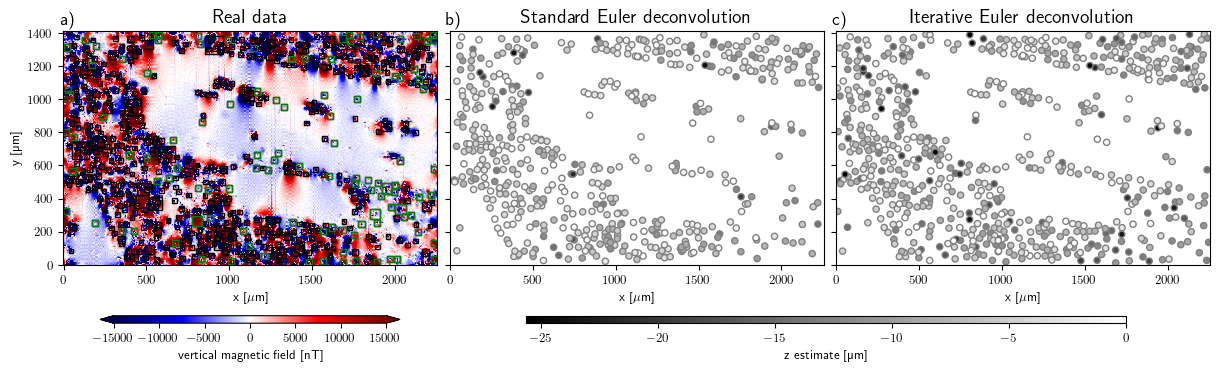

In [40]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid escape sequence '\c'
<>:197: DeprecationWarning: invalid escape sequence '\c'
<>:199: DeprecationWarning: invalid escape sequence '\c'
<>:201: DeprecationWarning: invalid escape sequence '\c'
<>:203: DeprecationWarning: invalid escape sequence '\c'
<>:206: DeprecationWarning: invalid escape sequence '\g'
<>:207: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:86: DeprecationWarning: invalid escape sequence '\m'
<>:114: DeprecationWarning: invalid escape sequence '\m'
<>:115: DeprecationWarning: invalid escape sequence '\m'
<>:195: DeprecationWarning: invalid e

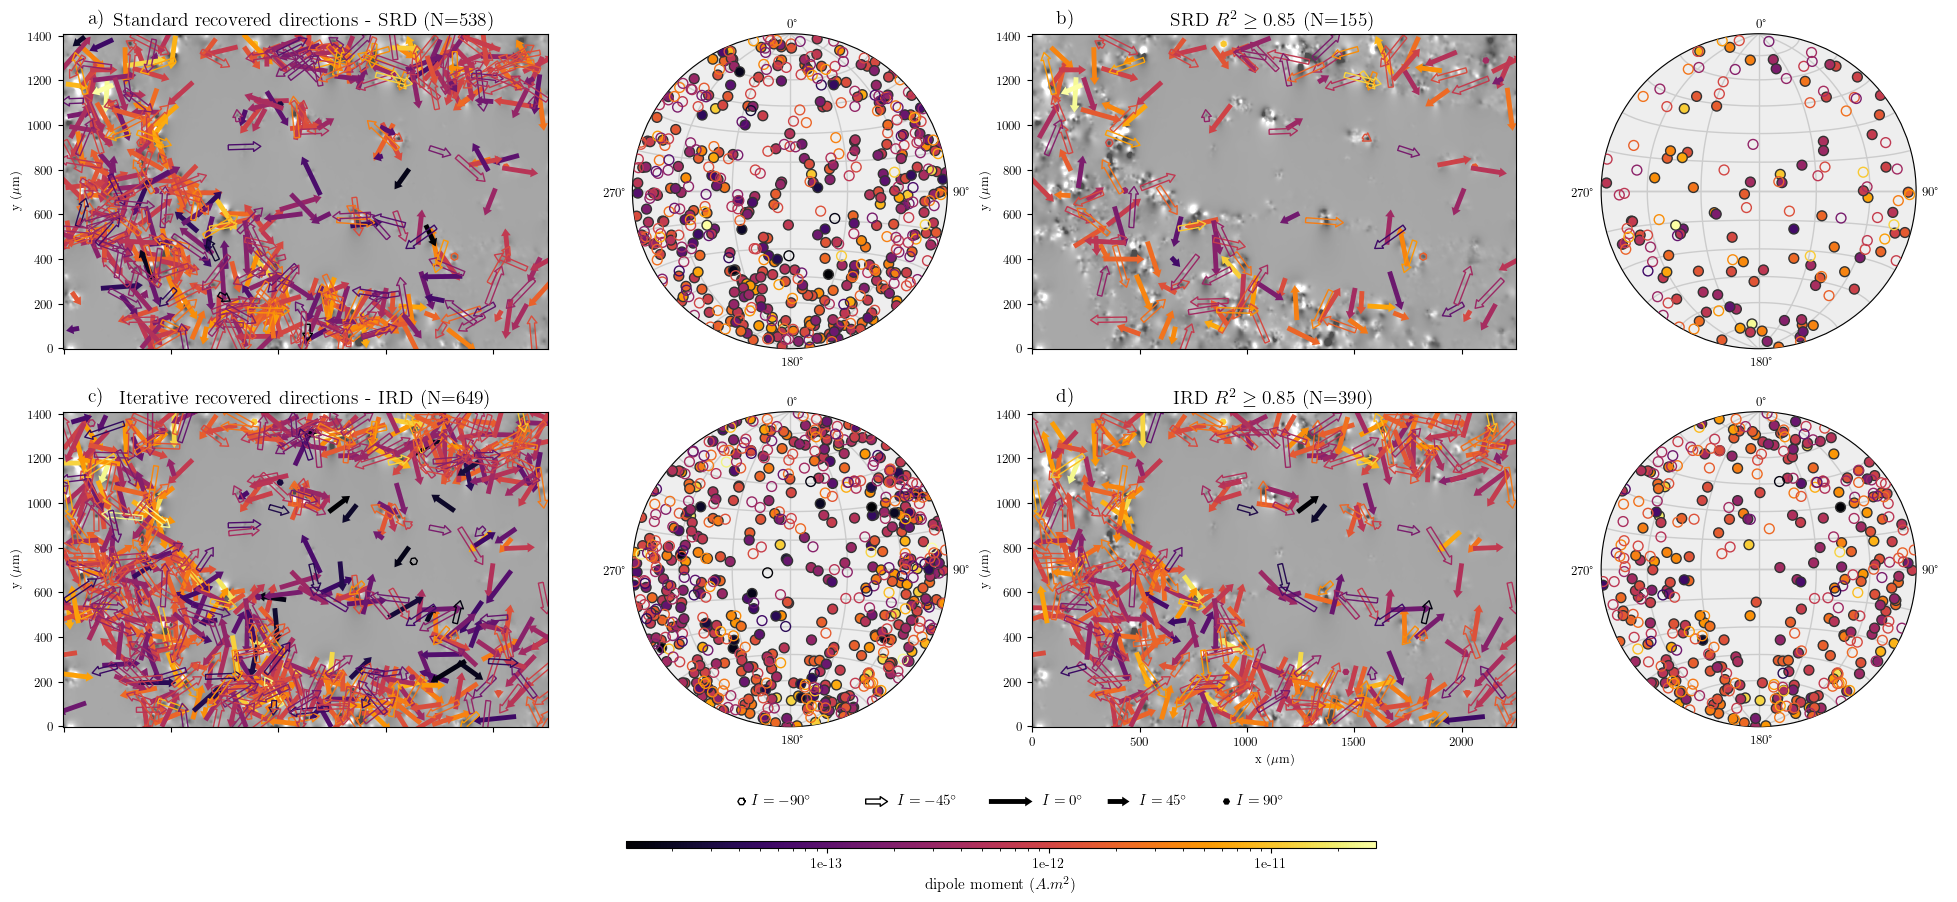

In [41]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

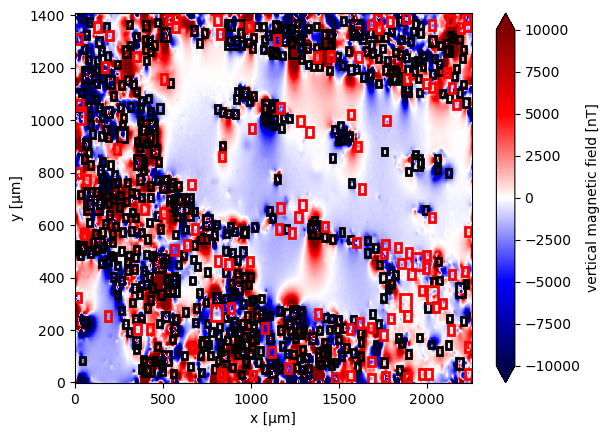

In [42]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [43]:
np.asarray(calculated_r2_itr_euler_enhanced).T

array([ 0.89387334,  0.95523906,  0.97452085,  0.96275645,  0.95857702,
        0.8258574 ,  0.95714908,  0.83979964,  0.97131164,  0.98137088,
        0.90356466,  0.95333421,  0.90738707,  0.93270106,  0.84675451,
        0.75648856,  0.92044802,  0.99468482,  0.97669657,  0.96858082,
        0.97687016,  0.95769221,  0.85804736,  0.92861012,  0.9638873 ,
        0.1326607 ,  0.72391916,  0.82472997,  0.99111405,  0.98869572,
        0.95244386,  0.88445321,  0.96542095,  0.90909718,  0.97367915,
        0.9543984 ,  0.93273211,  0.94143085,  0.95507757,  0.90449973,
        0.80427721,  0.95071526,  0.93407371,  0.00430507,  0.91473933,
        0.75907387,  0.91392398,  0.9717312 ,  0.89357576,  0.51330375,
        0.90135064,  0.28181128,  0.73109226,  0.75293138,  0.1297937 ,
        0.7616652 ,  0.94759392,  0.91295349,  0.61264716,  0.98555991,
        0.90074093,  0.87044166,  0.90369486,  0.9713342 ,  0.93521618,
        0.85400082,  0.96532498,  0.84943712,  0.92149188,  0.92

# Show the observed and predicted data

In [44]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

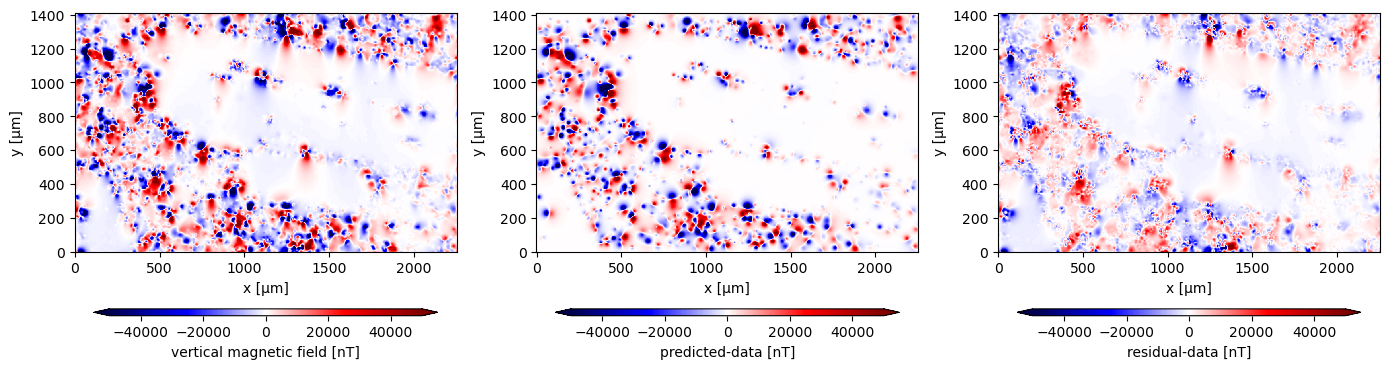

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +50000
    vmin = -50000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.8938733437750059


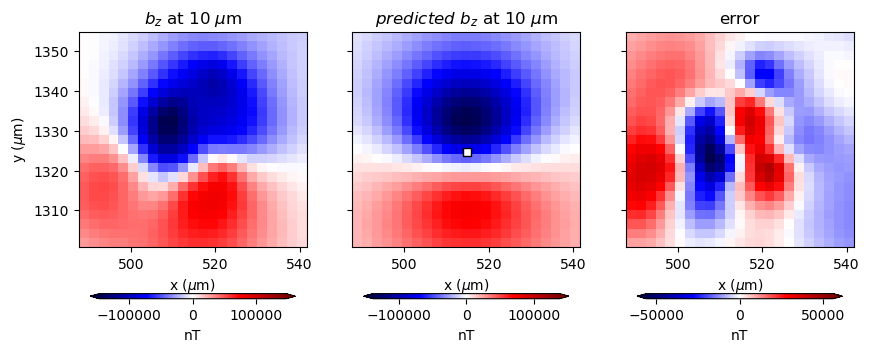

2
Individual source:   R2 = 0.9552390636419492


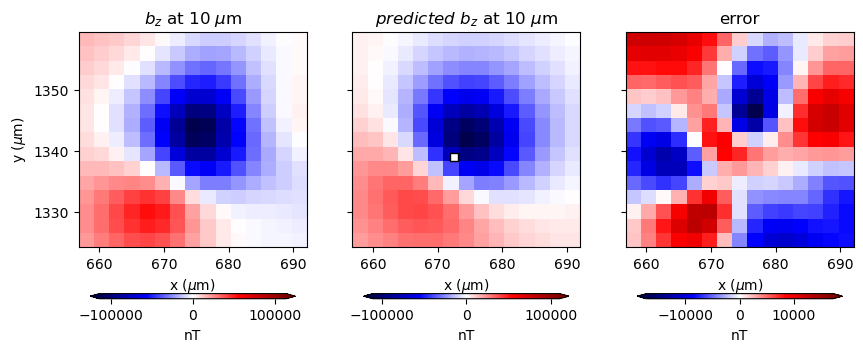

3
Individual source:   R2 = 0.9745208481775299


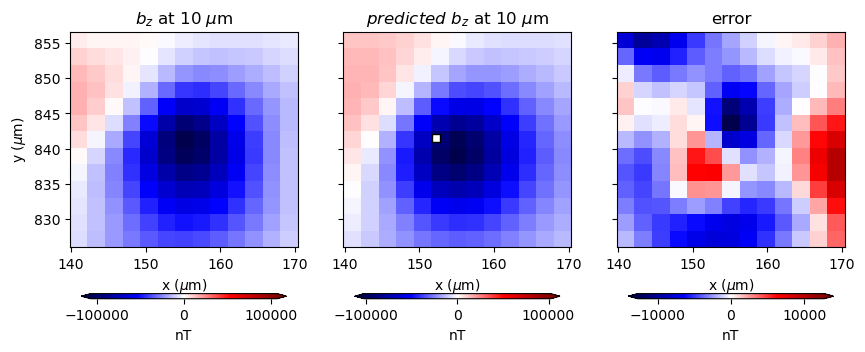

4
Individual source:   R2 = 0.9627564472239218


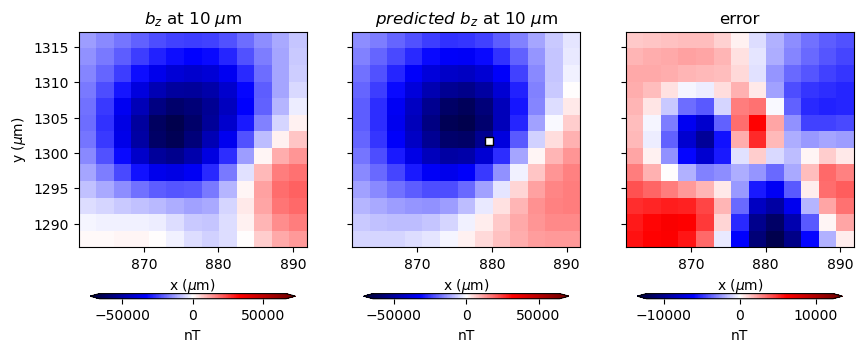

5
Individual source:   R2 = 0.9585770216815643


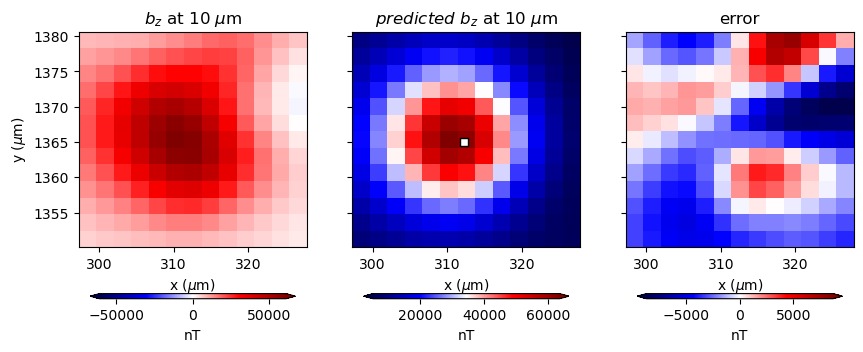

6
Individual source:   R2 = 0.8258574008215953


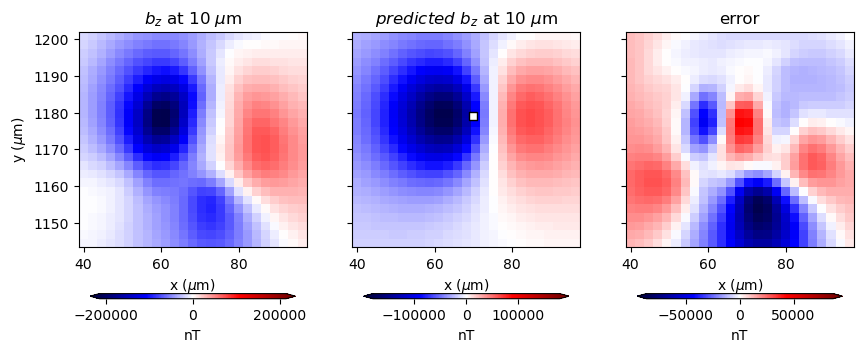

7
Individual source:   R2 = 0.9571490829339138


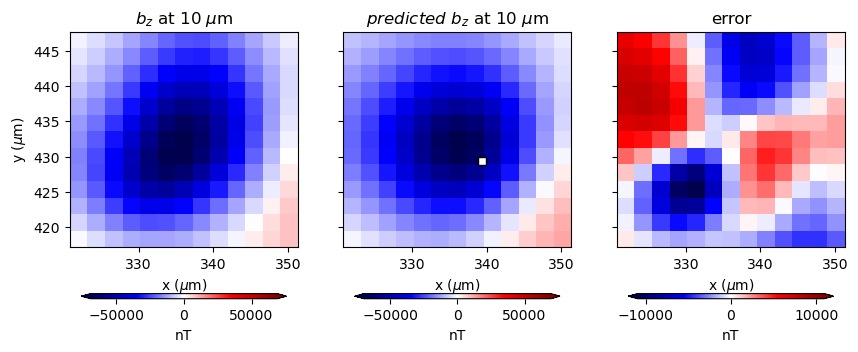

8
Individual source:   R2 = 0.8397996408383606


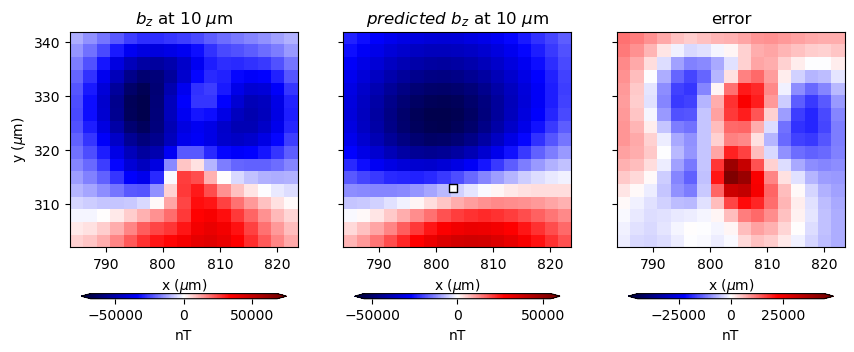

9
Individual source:   R2 = 0.9713116387892693


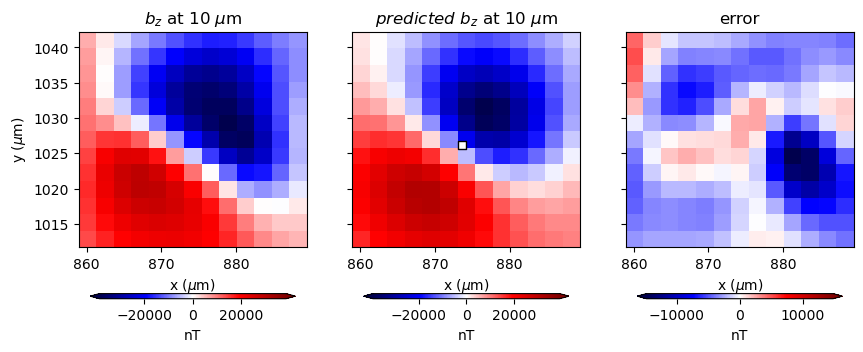

10
Individual source:   R2 = 0.9813708762485207


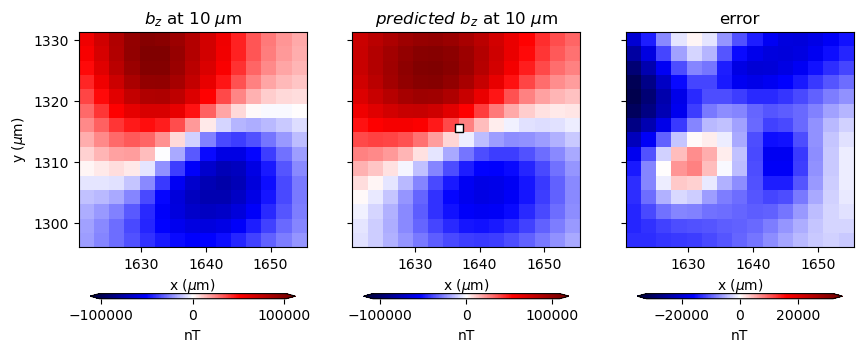

In [46]:
i = 0
slice_start=0#-20
slice_end=10#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [47]:
# Nome do arquivo ZIP
import os
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [48]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'xmin': np.asarray(windows)[:, 0],
    'xmax': np.asarray(windows)[:, 1],
    'ymin': np.asarray(windows)[:, 2],
    'ymax': np.asarray(windows)[:, 3],
    'xc_standard': np.asarray(positions)[0, :],
    'yc_standard': np.asarray(positions)[1, :],
    'zc_standard': np.asarray(positions)[2, :],
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'xmin': np.asarray(windows_enhanced)[:, 0],
    'xmax': np.asarray(windows_enhanced)[:, 1],
    'ymin': np.asarray(windows_enhanced)[:, 2],
    'ymax': np.asarray(windows_enhanced)[:, 3],
    'xc_iterative': np.asarray(positions_itr_enhanced)[0, :],
    'yc_iterative': np.asarray(positions_itr_enhanced)[1, :],
    'zc_iterative': np.asarray(positions_itr_enhanced)[2, :],
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)